In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [24]:
model = torch.load('../data storage/prm_data_L16_FCNN_Nh3.pth')
model

OrderedDict([('fc1.weight',
              tensor([[ 8.0332e-02, -4.6897e-02,  1.0126e-01, -3.0832e-01, -1.3782e-01,
                       -3.5701e-01, -2.4277e-01, -2.7459e-01, -3.2316e-01, -1.1191e-01,
                        2.6629e-02, -9.8047e-02, -3.9892e-02,  4.7267e-03, -4.2583e-02,
                        1.7183e-01, -1.8490e-01, -1.4729e-01, -1.5178e-01, -1.8485e-01,
                       -3.4054e-01, -4.4353e-01, -2.9368e-01, -4.5328e-01, -2.6654e-01,
                       -9.4076e-02,  1.2776e-01, -1.1721e-01,  1.7931e-01,  3.8393e-03,
                        1.3381e-01,  1.9412e-01, -1.9880e-01, -1.7708e-01, -3.9552e-01,
                       -5.4446e-01, -1.5842e-01, -3.4736e-01, -3.5046e-01, -4.7096e-01,
                       -4.0042e-01, -2.1083e-01, -2.2375e-02, -8.8684e-02, -1.6575e-01,
                        6.7989e-02,  2.6450e-02,  1.1954e-02, -1.6693e-01, -1.9916e-01,
                       -3.1228e-01, -3.6272e-01, -2.3877e-01, -1.4579e-01, -2.0153e-01,
    

In [25]:
fc_weight = model['fc2.weight']
fc_weight

tensor([[ 0.8326, -1.7031,  0.6851],
        [ 0.7223, -2.1237,  0.2762],
        [ 0.7955, -1.8671,  0.6105],
        [ 0.4818, -2.2462,  0.3343],
        [ 0.1689, -2.7888,  0.2139],
        [ 0.9806, -2.5960,  0.6896],
        [ 0.9576, -2.7673,  0.9376],
        [-0.0283, -2.5943, -0.1713],
        [-2.4414, -0.3610, -2.7773],
        [-3.7832,  0.3787, -4.0250],
        [-4.7867,  0.2177, -5.3048],
        [-5.2808,  0.8117, -5.9717],
        [-5.7943,  0.3112, -6.1976],
        [-6.1319,  0.6846, -5.9822],
        [-5.8647,  0.3138, -6.2975],
        [-5.8779,  0.2174, -6.6616],
        [-5.9768,  0.1321, -6.7704],
        [-6.4945,  0.6874, -6.5928],
        [-6.3124,  0.3016, -6.6782],
        [-6.4419,  0.8344, -6.2336]])

In [26]:
fc_weight.size()

torch.Size([20, 3])

In [27]:
# NumPy配列に変換
fc_weight_np = fc_weight.cpu().numpy()
# データを転置して
fc_weight_np_square = fc_weight_np.T

In [28]:
fc_weight_np_square

array([[ 0.83259135,  0.72230273,  0.7954788 ,  0.4817903 ,  0.16886812,
         0.9805793 ,  0.95760477, -0.02832284, -2.4413514 , -3.7831686 ,
        -4.7866936 , -5.2808137 , -5.7943497 , -6.1319137 , -5.8647017 ,
        -5.8779454 , -5.976778  , -6.4944534 , -6.3124485 , -6.441899  ],
       [-1.7030948 , -2.1237283 , -1.8670706 , -2.2462175 , -2.7887993 ,
        -2.596012  , -2.767292  , -2.5942628 , -0.3610339 ,  0.37874144,
         0.2176659 ,  0.8117047 ,  0.31124613,  0.6846049 ,  0.31379429,
         0.21739899,  0.13211074,  0.68739074,  0.30160323,  0.8344199 ],
       [ 0.68511444,  0.27620718,  0.61048687,  0.33427116,  0.21389328,
         0.6896455 ,  0.93763906, -0.17131706, -2.7773051 , -4.0250425 ,
        -5.3047724 , -5.971731  , -6.1975503 , -5.982194  , -6.297534  ,
        -6.661609  , -6.770384  , -6.5927587 , -6.6782413 , -6.233624  ]],
      dtype=float32)

In [29]:
fc_weight_np_square.shape

(3, 20)

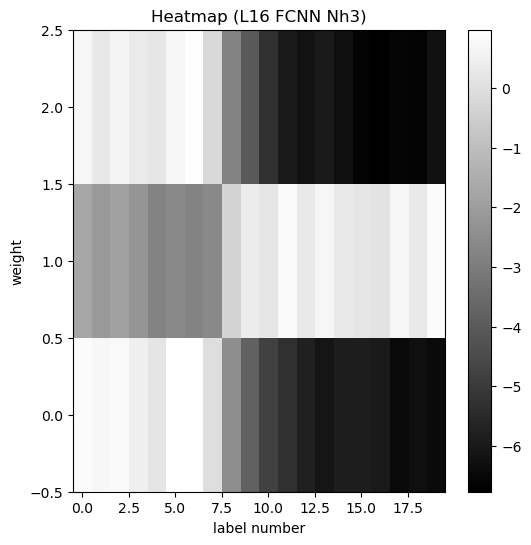

In [30]:
# ヒートマップをプロット（白黒）
plt.figure(figsize=(6, 6))
plt.imshow(fc_weight_np_square, cmap='gray', interpolation='nearest', origin='lower', aspect='auto')
plt.colorbar()
plt.title('Heatmap (L16 FCNN Nh3)')


# x軸とy軸に名前を付ける
plt.ylabel('weight')
plt.xlabel('label number')
# 図をファイルとして保存
plt.savefig('../image storage/L16_FCNN_Nh3_wight.png')
plt.show()

In [31]:
fc_weight_np_square_sum = np.sum(fc_weight_np_square, axis=0)
fc_weight_np_square_sum

array([ -0.18538904,  -1.1252184 ,  -0.46110487,  -1.430156  ,
        -2.406038  ,  -0.9257872 ,  -0.8720482 ,  -2.7939029 ,
        -5.5796905 ,  -7.4294696 ,  -9.8738    , -10.44084   ,
       -11.680655  , -11.4295025 , -11.848442  , -12.322155  ,
       -12.615051  , -12.399821  , -12.689087  , -11.841103  ],
      dtype=float32)

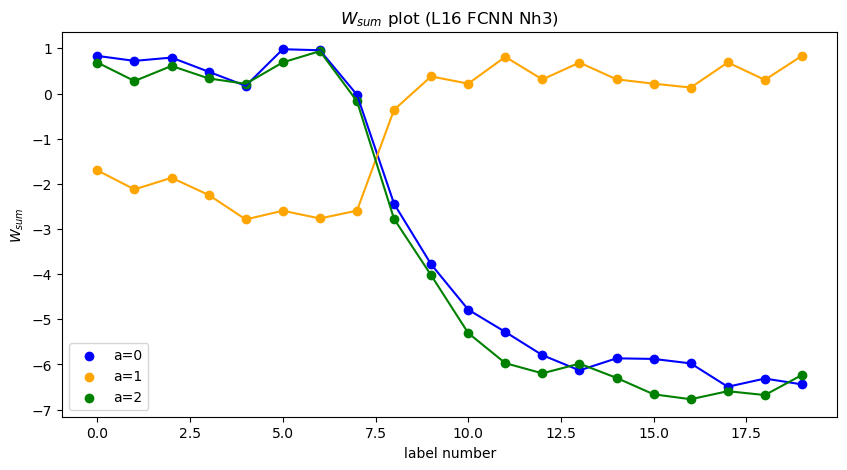

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# データ
x = np.arange(len(fc_weight_np_square[1]))
y0 = fc_weight_np_square[0]
y1 = fc_weight_np_square[1]
y2 = fc_weight_np_square[2]

# プロット
plt.figure(figsize=(10, 5))
plt.scatter(x, y0, color='blue', label='a=0')
plt.scatter(x, y1, color='orange', label='a=1')
plt.scatter(x, y2, color='green', label='a=2')
plt.plot(x, y0, color='blue')
plt.plot(x, y1, color='orange')
plt.plot(x, y2, color='green')
plt.title('$W_{sum}$ plot (L16 FCNN Nh3)')
plt.xlabel('label number')
plt.ylabel('$W_{sum}$')

plt.legend()  # 凡例を表示
plt.show()